In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import xarray as xr
import tensorflow as tf
import datetime
from shared.models import *
from shared.utilities import *
from shared.training import train_and_evaluate, split_data_on_participants
from shared.normalization import *
from shared.generators import *
import random
import visualkeras
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


### Set up data

In [2]:
data_path = Path("data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [8]:
train_data, val_data, test_data = split_data_on_participants(data, 60, norm_0_to_1)

In [3]:
model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

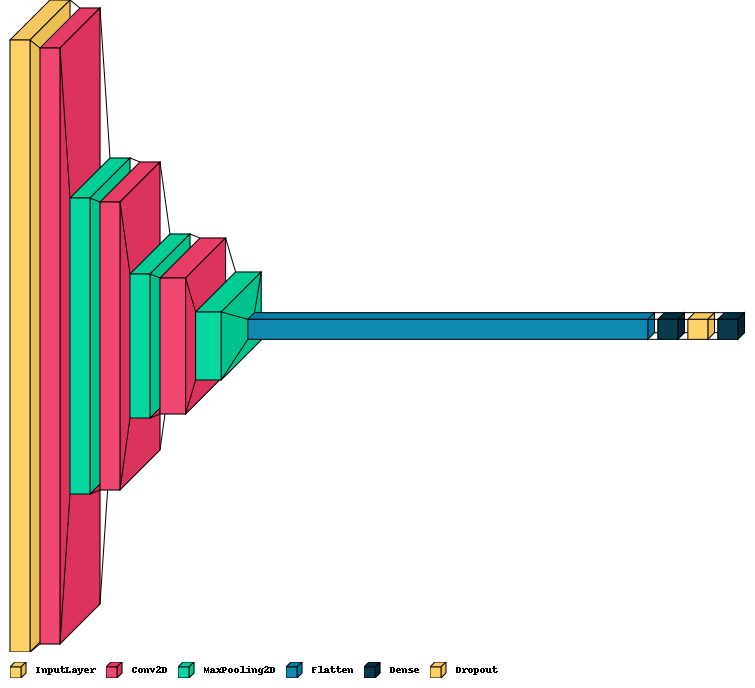

In [5]:
visualkeras.layered_view(model, legend=True)

In [12]:
train_and_evaluate(model, train_data, val_data, test_data, epochs=20)

Epoch 1/20
765/765 [==============================] - 20s 25ms/step - loss: 1.2704 - accuracy: 0.4333 - val_loss: 1.0645 - val_accuracy: 0.5400
Epoch 2/20
765/765 [==============================] - 11s 14ms/step - loss: 1.1189 - accuracy: 0.5237 - val_loss: 0.9104 - val_accuracy: 0.6288
Epoch 3/20
765/765 [==============================] - 11s 14ms/step - loss: 0.9524 - accuracy: 0.6125 - val_loss: 0.7460 - val_accuracy: 0.6999
Epoch 4/20
765/765 [==============================] - 11s 14ms/step - loss: 0.8257 - accuracy: 0.6793 - val_loss: 0.6498 - val_accuracy: 0.7409
Epoch 5/20
765/765 [==============================] - 11s 14ms/step - loss: 0.7613 - accuracy: 0.7105 - val_loss: 0.6083 - val_accuracy: 0.7584
Epoch 6/20
765/765 [==============================] - 11s 14ms/step - loss: 0.7156 - accuracy: 0.7282 - val_loss: 0.5742 - val_accuracy: 0.7847
Epoch 7/20
765/765 [==============================] - 11s 14ms/step - loss: 0.6701 - accuracy: 0.7440 - val_loss: 0.5310 - val_accuracy:

In [10]:
# Run before re-training to clear up VRAM
import gc

gc.collect()
tf.keras.backend.clear_session()
del model

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 147, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 30, 143, 64)       384       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 71, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 69, 128)       24704     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 32, 256)       98560 